## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2020.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know how to build basic fully connected neural network.

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers
In this part, all the functions will be created from scratch using numpy for better understanding. (In the next task, you will be introduced to built in layers from tensorflow.)

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [486]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check by tfe.gradients_function()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))

out_check = out_tf.numpy()
dx_check, dw_check, db_check = dx_tf.numpy(), dw_tf.numpy(), db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [130]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    out_tf = tf.nn.relu(x_tf)
    grad_gt = tape.gradient(out_tf, x_tf)

out_check = out_tf.numpy()
dx_check = grad_gt.numpy()
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [4]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

## check by tf.GradientTape.gradients()

x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')

with tf.GradientTape() as tape:
    tape.watch(x_tf)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= x_tf, labels=tf.one_hot(y_tf,10))
    loss_tf = tf.reduce_mean(cross_entropy)
    dx_tf = tape.gradient(loss_tf, x_tf)

loss_check = loss_tf.numpy()
dx_check = dx_tf.numpy()
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print(loss, loss_check)

Is loss correct? True
Is dx correct? True
1.938847735557068 1.938847735557068


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [5]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = affine_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [291]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

## check by tf.GradientTape.gradients()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

with tf.GradientTape() as tape:
    tape.watch(w_tf)
    out_tf = dense_layer(x_tf, w_tf, b_tf)
    dx_tf, dw_tf, db_tf = tape.gradient(out_tf, (x_tf, w_tf, b_tf))
    
out_check = out_tf.numpy()
dx_check = dx_tf.numpy()
dw_check = dw_tf.numpy()
db_check = db_tf.numpy()

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: Two Layer Network

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

## Part 2: Two Layer Network

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**

<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [6]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.Variable(X_dev, dtype = tf.float32)
y_tf = tf.Variable(y_dev, dtype = tf.uint8)

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 

loss_check=loss_tf.numpy()
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print(loss, loss_check)

Is loss correct? True
2.3234475630232123 2.3234477


### Train a two-layer network

#### Import functions for training and testing

In [7]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [309]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

#from utils.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 4.488680372859634
10000/49000 loss: 2.7620094603607566
15000/49000 loss: 3.136366850253388
20000/49000 loss: 2.272310747626861
25000/49000 loss: 2.3562566623056336
30000/49000 loss: 2.237067494619995
35000/49000 loss: 2.2377716493830504
40000/49000 loss: 2.1383655917365636
45000/49000 loss: 2.207595201543683
epoch 1: valid acc = 0.206, new learning rate = 0.00046
5000/49000 loss: 2.1498437089030773
10000/49000 loss: 2.125598785230455
15000/49000 loss: 2.0797105946841556
20000/49000 loss: 2.0816242231932014
25000/49000 loss: 2.072374596743459
30000/49000 loss: 2.040478605300162
35000/49000 loss: 2.013964083082805
40000/49000 loss: 1.9616064011843555
45000/49000 loss: 1.9590262569205046
epoch 2: valid acc = 0.242, new learning rate = 0.00042320000000000004
5000/49000 loss: 1.9370927047806648
10000/49000 loss: 1.954406712470202
15000/49000 loss: 1.9699292319868447
20000/49000 loss: 1.912933946413445
25000/49000 loss: 1.94798573728053
300

0.4196

<p style='color:red'><strong>TODO: Plot training and validation accuracy history of each epoch</strong></p>

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

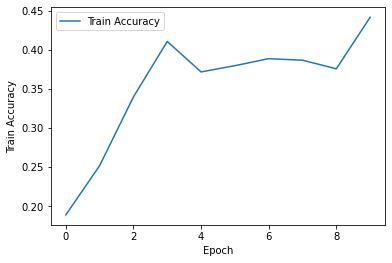

In [295]:
plt.plot(train_acc_hist, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

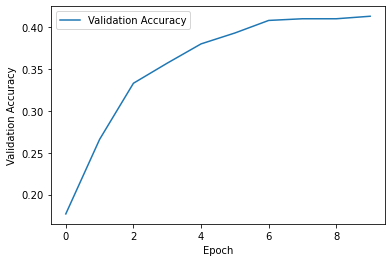

In [296]:
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [62]:
from utils.display_funcs import visualize_pics

num of feature vectors: 100


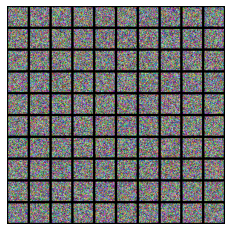

In [67]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 50%. If your accuracy is lower, for each 1% lower than 50%, you will lose 5 points.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<p style='color:red'><strong>TODO</strong></p>

In [468]:
from utils.classifiers.twolayernet import TwoLayerNet
# Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

In [482]:
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1, weight_scale=1e-3)

num_epoch = 15
batch_size = 300
lr = 1e-3
verbose = False
learning_decay = 0.93
momentum = .9
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, learning_decay = learning_decay, momentum = momentum, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 163
epoch 1: valid acc = 0.41, new learning rate = 0.00093
epoch 2: valid acc = 0.448, new learning rate = 0.0008649
epoch 3: valid acc = 0.468, new learning rate = 0.0008043570000000001
epoch 4: valid acc = 0.47, new learning rate = 0.0007480520100000002
epoch 5: valid acc = 0.474, new learning rate = 0.0006956883693000003
epoch 6: valid acc = 0.483, new learning rate = 0.0006469901834490003
epoch 7: valid acc = 0.48, new learning rate = 0.0006017008706075703
epoch 8: valid acc = 0.486, new learning rate = 0.0005595818096650405
epoch 9: valid acc = 0.485, new learning rate = 0.0005204110829884876
epoch 10: valid acc = 0.504, new learning rate = 0.00048398230717929355
epoch 11: valid acc = 0.508, new learning rate = 0.00045010354567674303
epoch 12: valid acc = 0.485, new learning rate = 0.000418596297479371
epoch 13: valid acc = 0.5, new learning rate = 0.0003892945566558151
epoch 14: valid acc = 0.493, new learning rate = 0.000362043937689908
epoch 15: 

0.4984

<p style='color:red'><strong>TODO</strong></p>

In [ ]:
## plot training and validation accuracy of your best model

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

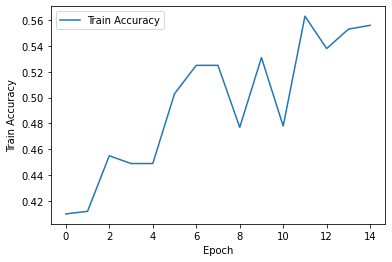

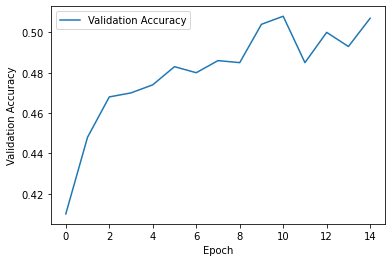

In [483]:
plt.plot(train_acc_hist, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
##  Visualize weights of the first layer

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

num of feature vectors: 100


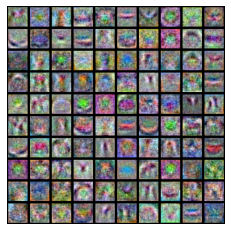

In [484]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [485]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## Load your model - FYI
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Network

Complete the class **MLP** in **./utils/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

In [437]:
from builtins import range
from builtins import object
import numpy as np

from utils.layer_funcs import *
from utils.layer_utils import *

class MLP(object):
    """
    MLP with an arbitrary number of dense hidden layers,
    and a softmax loss function. For a network with L layers,
    the architecture will be

    input >> DenseLayer x (L - 1) >> AffineLayer >> softmax_loss >> output

    Here "x (L - 1)" indicate to repeat L - 1 times. 
    """
    def __init__(self, input_dim=3072, hidden_dims=[200,200], num_classes=10, reg=0.0, weight_scale=1e-3):
        """
        Inputs:
        - reg: (float) L2 regularization
        - weight_scale: (float) for layer weight initialization
        """
        self.num_layers = len(hidden_dims) + 1
        self.reg = reg
        
        dims = [input_dim] + hidden_dims
        layers = []
        for i in range(len(dims)-1):
            layers.append(DenseLayer(input_dim=dims[i], output_dim=dims[i+1], weight_scale=weight_scale))
        layers.append(AffineLayer(input_dim=dims[-1], output_dim=num_classes, weight_scale=weight_scale))
        
        self.layers = layers

    def loss(self, X, y):
        """
        Calculate the cross-entropy loss and then use backpropogation
        to get gradients wst W,b in each layer.
        
        Inputs:
        - X: input data
        - y: ground truth
        
        Return loss value(float)
        """
        loss = 0.0
        reg = self.reg
        num_layers = self.num_layers
        layers = self.layers
        
        ####################################################
        #           START OF YOUR CODE           #
        ####################################################
        ####################################################
        # TODO: Feedforward                      #
        ####################################################
        output = []
        output.append(layers[0].feedforward(X))
        for i in range(1,num_layers):
            out = layers[i].feedforward(output[i-1])
            output.append(out)
            
        loss, dy = softmax_loss(output[num_layers-1], y)
            
        ####################################################
        # TODO: Backpropogation                   #
        ####################################################
        dout = {}
        dout["dX"+str(num_layers)] = dy
        for i in range(num_layers):
            dout["dX"+str(num_layers-i-1)] = layers[num_layers-i-1].backward(dout["dX"+str(num_layers-i)])

        
#         dX3 = dy
#         dX2 = layer2.backward(dX3)
#         dX1 = layer1.backward(dX2)
#         dX0 = layer0.backward(dx1)
        ####################################################
        # TODO: Add L2 regularization               #
        ####################################################
        square_weights = 0
        for i in range(num_layers):
            square_weights+=np.sum(layers[i].params[0]**2) 
        
        loss += 0.5*self.reg*square_weights
        
        ####################################################
        #            END OF YOUR CODE            #
        ####################################################
        
        
        return loss

    def step(self, learning_rate=1e-5):
        """
        Use SGD to implement a single-step update to each weight and bias.
        """
        ####################################################
        # TODO: Use SGD to update variables in layers.     #
        ####################################################
        ####################################################
        #           START OF YOUR CODE                     #
        ####################################################
        layers = self.layers
        num_layers = self.num_layers
        
        params = [] # create list of params
        for i in range(num_layers):
            params.append(layers[i].params[0])
            params.append(layers[i].params[1])
        
        grads = [] # create list of gradients
        for i in range(num_layers):
            grads.append(layers[i].gradients[0])
            grads.append(layers[i].gradients[1])
        
        
        for i in range(2*(num_layers)): # update gradients
            params[i] = params[i] - learning_rate * grads[i]
            
        
        ####################################################
        #            END OF YOUR CODE                      #
        ####################################################
        
   
        # update parameters in layers
        for i in range(num_layers):
            self.layers[i].update_layer(params[2*i:2*(i+1)])
        

    def predict(self, X):
        """
        Return the label prediction of input data
        
        Inputs:
        - X: (float) a tensor of shape (N, D)
        
        Returns: 
        - predictions: (int) an array of length N
        """
        predictions = None
        num_layers = self.num_layers
        layers = self.layers
        #####################################################
        # TODO: Remember to use functions in class          #
        # SoftmaxLayer                                      #
        #####################################################
        ####################################################
        #           START OF YOUR CODE                     #
        ####################################################
        output = []
        output.append(layers[0].feedforward(X))
        for i in range(1,num_layers):
            out = layers[i].feedforward(output[i-1])
            output.append(out)
        
        predictions = np.argmax(output[num_layers-1], axis=1)
        
        ####################################################
        #            END OF YOUR CODE                      #
        ####################################################
        
        return predictions
    
    def check_accuracy(self, X, y):
        """
        Return the classification accuracy of input data
        
        Inputs:
        - X: (float) a tensor of shape (N, D)
        - y: (int) an array of length N. ground truth label 
        Returns: 
        - acc: (float) between 0 and 1
        """
        y_pred = self.predict(X)
        acc = np.mean(np.equal(y, y_pred))
        
        return acc
        
        


<span style="color:red"><strong>NOTE</strong></span>: Please do not change the code in the cell below, The cell below will run correctly if your code is right.

In [445]:
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #

from utils.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.157, new learning rate = 0.0092
epoch 2: valid acc = 0.218, new learning rate = 0.008464000000000001
epoch 3: valid acc = 0.229, new learning rate = 0.007786880000000001
epoch 4: valid acc = 0.292, new learning rate = 0.007163929600000001
epoch 5: valid acc = 0.326, new learning rate = 0.0065908152320000015
epoch 6: valid acc = 0.368, new learning rate = 0.006063550013440002
epoch 7: valid acc = 0.394, new learning rate = 0.005578466012364802
epoch 8: valid acc = 0.429, new learning rate = 0.005132188731375617
epoch 9: valid acc = 0.445, new learning rate = 0.0047216136328655685
epoch 10: valid acc = 0.439, new learning rate = 0.004343884542236323
test acc: 0.4385


0.4385

<p style='color:red'><strong>TODO:</strong></p>

In [ ]:
# plot training and validation accuracy

<p style='color:red'><strong>SOLUTION (enter a new cell below):</strong></p>

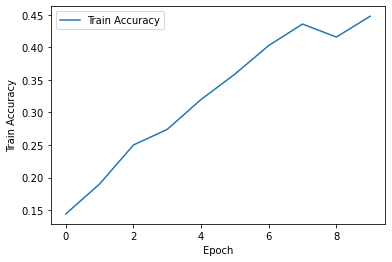

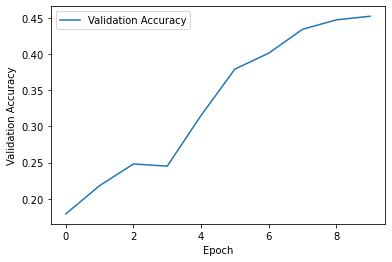

In [443]:
plt.plot(train_acc_hist, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.plot(val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()